# Bone fracture prediction and classification

#### Importing all required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

In [2]:
Image_Size = 256
Batch_Size = 64
Channels = 3
Epochs = 28

#### Import Data

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data_JPEG",
    shuffle = True,
    image_size = (Image_Size, Image_Size),
    batch_size = Batch_Size
)

Found 1725 files belonging to 12 classes.


#### Exploring data

In [4]:
classes = dataset.class_names
classes

['Avulsion fracture',
 'Comminuted fracture',
 'Compression-Crush fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Intra-articular fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

In [5]:
len(dataset)

27

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[ 5  3  3 11  0  3  8 11 11 11  8  1  6  4  7  7  9  6  2  1  0  1  4  8
 10  2  0  5  6  0  1  1  3  4  6  2  4  5  4  5  7 11  0  9 10  2 11  8
  9 10  1 10  1  5  8  1  3  1  8  8  6  1  0 11]


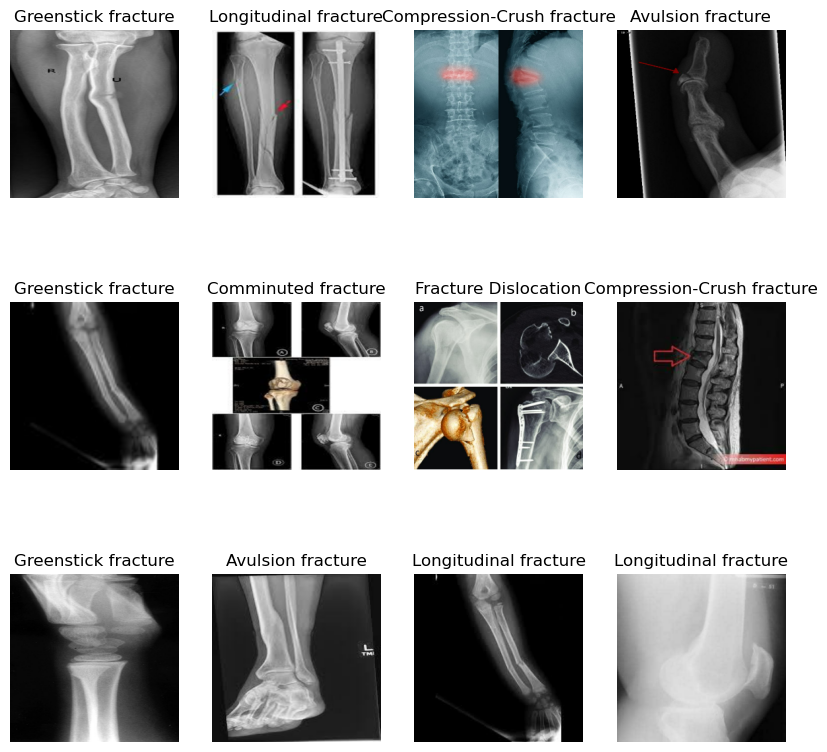

In [7]:
plt.figure(num=10, figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

#### Train Test Split

80% ==> training
20% ==> 10% validation, 10% test

In [8]:
def dataset_get_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = dataset_get_partitions_tf(dataset)

In [10]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

21
2
4


#### Shuffling data

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Creating Layers and Model Building

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(12, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)       

In [16]:
# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [18]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [19]:
# Train the model with more epochs
history = model.fit(
    train_ds,
    epochs=Epochs,  # Increase the number of epochs
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/28
21/21 [==============================] - 84s 4s/step - loss: 9.2326 - accuracy: 0.0850 - val_loss: 2.4663 - val_accuracy: 0.0703
Epoch 2/28
21/21 [==============================] - 82s 4s/step - loss: 2.4286 - accuracy: 0.1469 - val_loss: 2.3862 - val_accuracy: 0.1797
Epoch 3/28
21/21 [==============================] - 46s 2s/step - loss: 2.3122 - accuracy: 0.2043 - val_loss: 2.2940 - val_accuracy: 0.1875
Epoch 4/28
21/21 [==============================] - 21s 1s/step - loss: 2.1385 - accuracy: 0.2752 - val_loss: 2.0084 - val_accuracy: 0.3438
Epoch 5/28
21/21 [==============================] - 22s 1s/step - loss: 1.8689 - accuracy: 0.3885 - val_loss: 1.9027 - val_accuracy: 0.4141
Epoch 6/28
21/21 [==============================] - 22s 1s/step - loss: 1.6443 - accuracy: 0.4407 - val_loss: 1.8338 - val_accuracy: 0.4297
Epoch 7/28
21/21 [==============================] - 22s 1s/step - loss: 1.5005 - accuracy: 0.5160 - val_loss: 1.6790 - val_accuracy: 0.4922
Epoch 8/28
21/21 [==

In [20]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 3s 313ms/step - loss: 1.3267 - accuracy: 0.7266


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

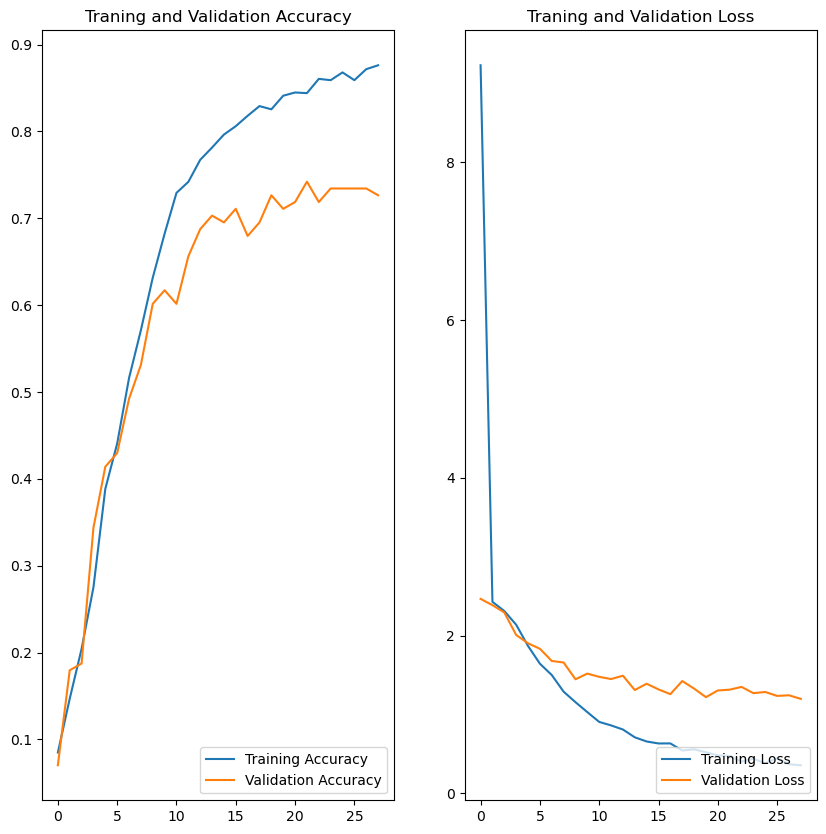

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Traning and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(Epochs), loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Traning and Validation Loss')
plt.show()